## Mounting Google Drive in Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Clone yolov5 repository**

In [ ]:
%cd /content/
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install
import torch
import utils
display = utils.notebook_init()  # checks
%cd ../

YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.7/78.2 GB disk)
/content


# (dataset folder path)

In [ ]:
%cd /content/drive/MyDrive/data/strawberry_dataset

/content/drive/MyDrive/data/strawberry_dataset


### unzip the dataset zip file in the /content directory

In [ ]:
import os

# Define paths
drive_path = '/content/drive/MyDrive/data/strawberry_dataset'
zip_file_path = os.path.join(drive_path, 'strawberry.zip')  # zip file name
extract_to_path = '/content'  # Path where you want to unzip the files

In [ ]:
%cd /content


/content


In [ ]:
!mkdir dataset


In [ ]:
# Create the directory if it doesn't exist
# %cd /content
os.makedirs(extract_to_path, exist_ok=True)

# Unzip the file
!unzip -q "{zip_file_path}" -d "{extract_to_path}"

## move annotation.xml to annotation_file directory

In [ ]:
# %pwd
%cd /content
!mkdir annotations_file

import shutil

# Specify the paths
source = '/content/annotations.xml'
destination = '/content/annotations_file/'

# Move the file
shutil.move(source, destination)


/content


'/content/annotations_file/annotations.xml'

### create labels directory in dataset to store .txt file

In [ ]:
%cd /content/dataset
!mkdir labels
%cd labels

/content/dataset
/content/dataset/labels


## Parse the xml annotation File in yolo formate

In [ ]:
import xml.etree.ElementTree as ET
import os

def convert_xml_to_yolo(xml_file, output_dir, class_map):
    # Parse XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Process each image
    for image in root.findall('image'):
        image_name = image.get('name')
        image_width = int(image.get('width'))
        image_height = int(image.get('height'))

        # Prepare output file path
        base_name = os.path.basename(image_name)
        txt_file = os.path.join(output_dir, os.path.splitext(base_name)[0] + '.txt')
        os.makedirs(output_dir, exist_ok=True)

        with open(txt_file, 'w') as out_f:
            # Process each box
            for box in image.findall('box'):
                class_name = box.get('label')
                class_id = class_map.get(class_name, -1)  # Default to -1 if class not found

                # Extract bounding box coordinates
                xtl = float(box.get('xtl'))
                ytl = float(box.get('ytl'))
                xbr = float(box.get('xbr'))
                ybr = float(box.get('ybr'))

                # Compute width and height
                width = xbr - xtl
                height = ybr - ytl

                # Normalize values
                center_x = (xtl + width / 2) / image_width
                center_y = (ytl + height / 2) / image_height
                width_normalized = width / image_width
                height_normalized = height / image_height

                # Write to YOLO format file
                out_f.write(f"{class_id} {center_x} {center_y} {width_normalized} {height_normalized}\n")

# Example class mapping
class_map = {
    'strawberry': 0,
    # Add other class mappings if necessary
}

# Directory paths
input_dir = '/content/annotations_file'
output_dir = '/content/dataset/labels'

# Process each XML file
for xml_file in os.listdir(input_dir):
    if xml_file.endswith('.xml'):
        convert_xml_to_yolo(os.path.join(input_dir, xml_file), output_dir, class_map)


In [ ]:
%cd /content

/content


## Move the Images in dataset (Directory)

In [ ]:
import shutil
import os

# Specify the source and destination directories//// do it twice for images and labels///////
source_dir = '/content/images'
destination_dir = '/content/dataset'

# Construct the path for the new location of the source directory
destination_path = os.path.join(destination_dir, os.path.basename(source_dir))

# Move the directory
shutil.move(source_dir, destination_path)

print(f"Directory moved to {destination_path}")

Directory moved to /content/dataset/images


## split data (train and validation)

In [ ]:
import os
import shutil

# Paths
dataset_dir = '/content/dataset'
images_dir = os.path.join(dataset_dir, 'images')
labels_dir = os.path.join(dataset_dir, 'labels')

# Output directories
output_dir = '/content/dataset'
train_images_dir = os.path.join(output_dir, 'train/images')
train_labels_dir = os.path.join(output_dir, 'train/labels')
val_images_dir = os.path.join(output_dir, 'val/images')
val_labels_dir = os.path.join(output_dir, 'val/labels')

# Create the output directories
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Get list of all image and label files (ignoring hidden or non-matching files)
images = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
labels = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

# Ensure the same number of images and labels
assert len(images) == len(labels), "Mismatch between images and labels"

# Filter out files that don't have corresponding pairs
image_base_names = set(os.path.splitext(f)[0] for f in images)
label_base_names = set(os.path.splitext(f)[0] for f in labels)

common_base_names = image_base_names & label_base_names
images = [f for f in images if os.path.splitext(f)[0] in common_base_names]
labels = [f for f in labels if os.path.splitext(f)[0] in common_base_names]

# Ensure the same number of images and labels after filtering
assert len(images) == len(labels), "Mismatch between images and labels after filtering"

# Pair images and labels in the original order
data = list(zip(images, labels))

# Define split ratio
train_ratio = 0.8

# Calculate the split index
train_split = int(len(data) * train_ratio)

# Split the data into training and validation sets
train_data = data[:train_split]
val_data = data[train_split:]

# Function to copy files to the destination
def copy_files(data, images_dir, labels_dir, dest_images_dir, dest_labels_dir):
    for img_file, lbl_file in data:
        shutil.copy(os.path.join(images_dir, img_file), os.path.join(dest_images_dir, img_file))
        shutil.copy(os.path.join(labels_dir, lbl_file), os.path.join(dest_labels_dir, lbl_file))

# Copy the files to the corresponding directories
copy_files(train_data, images_dir, labels_dir, train_images_dir, train_labels_dir)
copy_files(val_data, images_dir, labels_dir, val_images_dir, val_labels_dir)

print("Dataset split into training and validation sets completed!")


Dataset split into training and validation sets completed!


In [ ]:
%pwd
%cd /content/yolov5

/content/yolov5


## strawberry.yaml for custom data

In [ ]:

yaml_content = """
train: /content/dataset/train/images
val: /content/dataset/val/images

nc: 1
names:
  0: 'riped'
"""

# Save the content to a file
with open("strawberry.yaml", "w") as file:
    file.write(yaml_content)



In [ ]:
%cd /content/dataset

/content/dataset


### data.yaml for custom data

In [ ]:
# ///////////////data.yaml////////////
yaml_content = """
train: /content/dataset/train/images
val: /content/dataset/val/images

nc: 1
names:
  0: 'riped'
"""

# Save the content to a file
with open("data.yaml", "w") as file:
    file.write(yaml_content)



In [ ]:
%cd /content/yolov5
%pwd

/content/yolov5


'/content/yolov5'

## **Training**

In [ ]:
!python train.py --img 640 --epochs 120 --data /content/yolov5/strawberry.yaml --weights yolov5s.pt


2024-08-16 12:41:21.466878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 12:41:21.493458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 12:41:21.499585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/yolov5/strawberry.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=120, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, 

# Inference on Validation Data

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source  /content/dataset/val/images

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/dataset/val/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-353-g5eca7b9c Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /content/dataset/val/images/12.png: 384x640 10 ripeds, 51.6ms
image 2/8 /content/dataset/val/images/16.png: 448x640 9 ripeds, 51.5ms
image 3/8 /content/dataset/val/images/19.png: 480x640 11 ripeds, 53.0ms
image 4/8 /content/dataset/val/images/22.png: 384x640 5 ripeds, 7.6ms
image 5/8 /content/d

# **Output of the validation images**

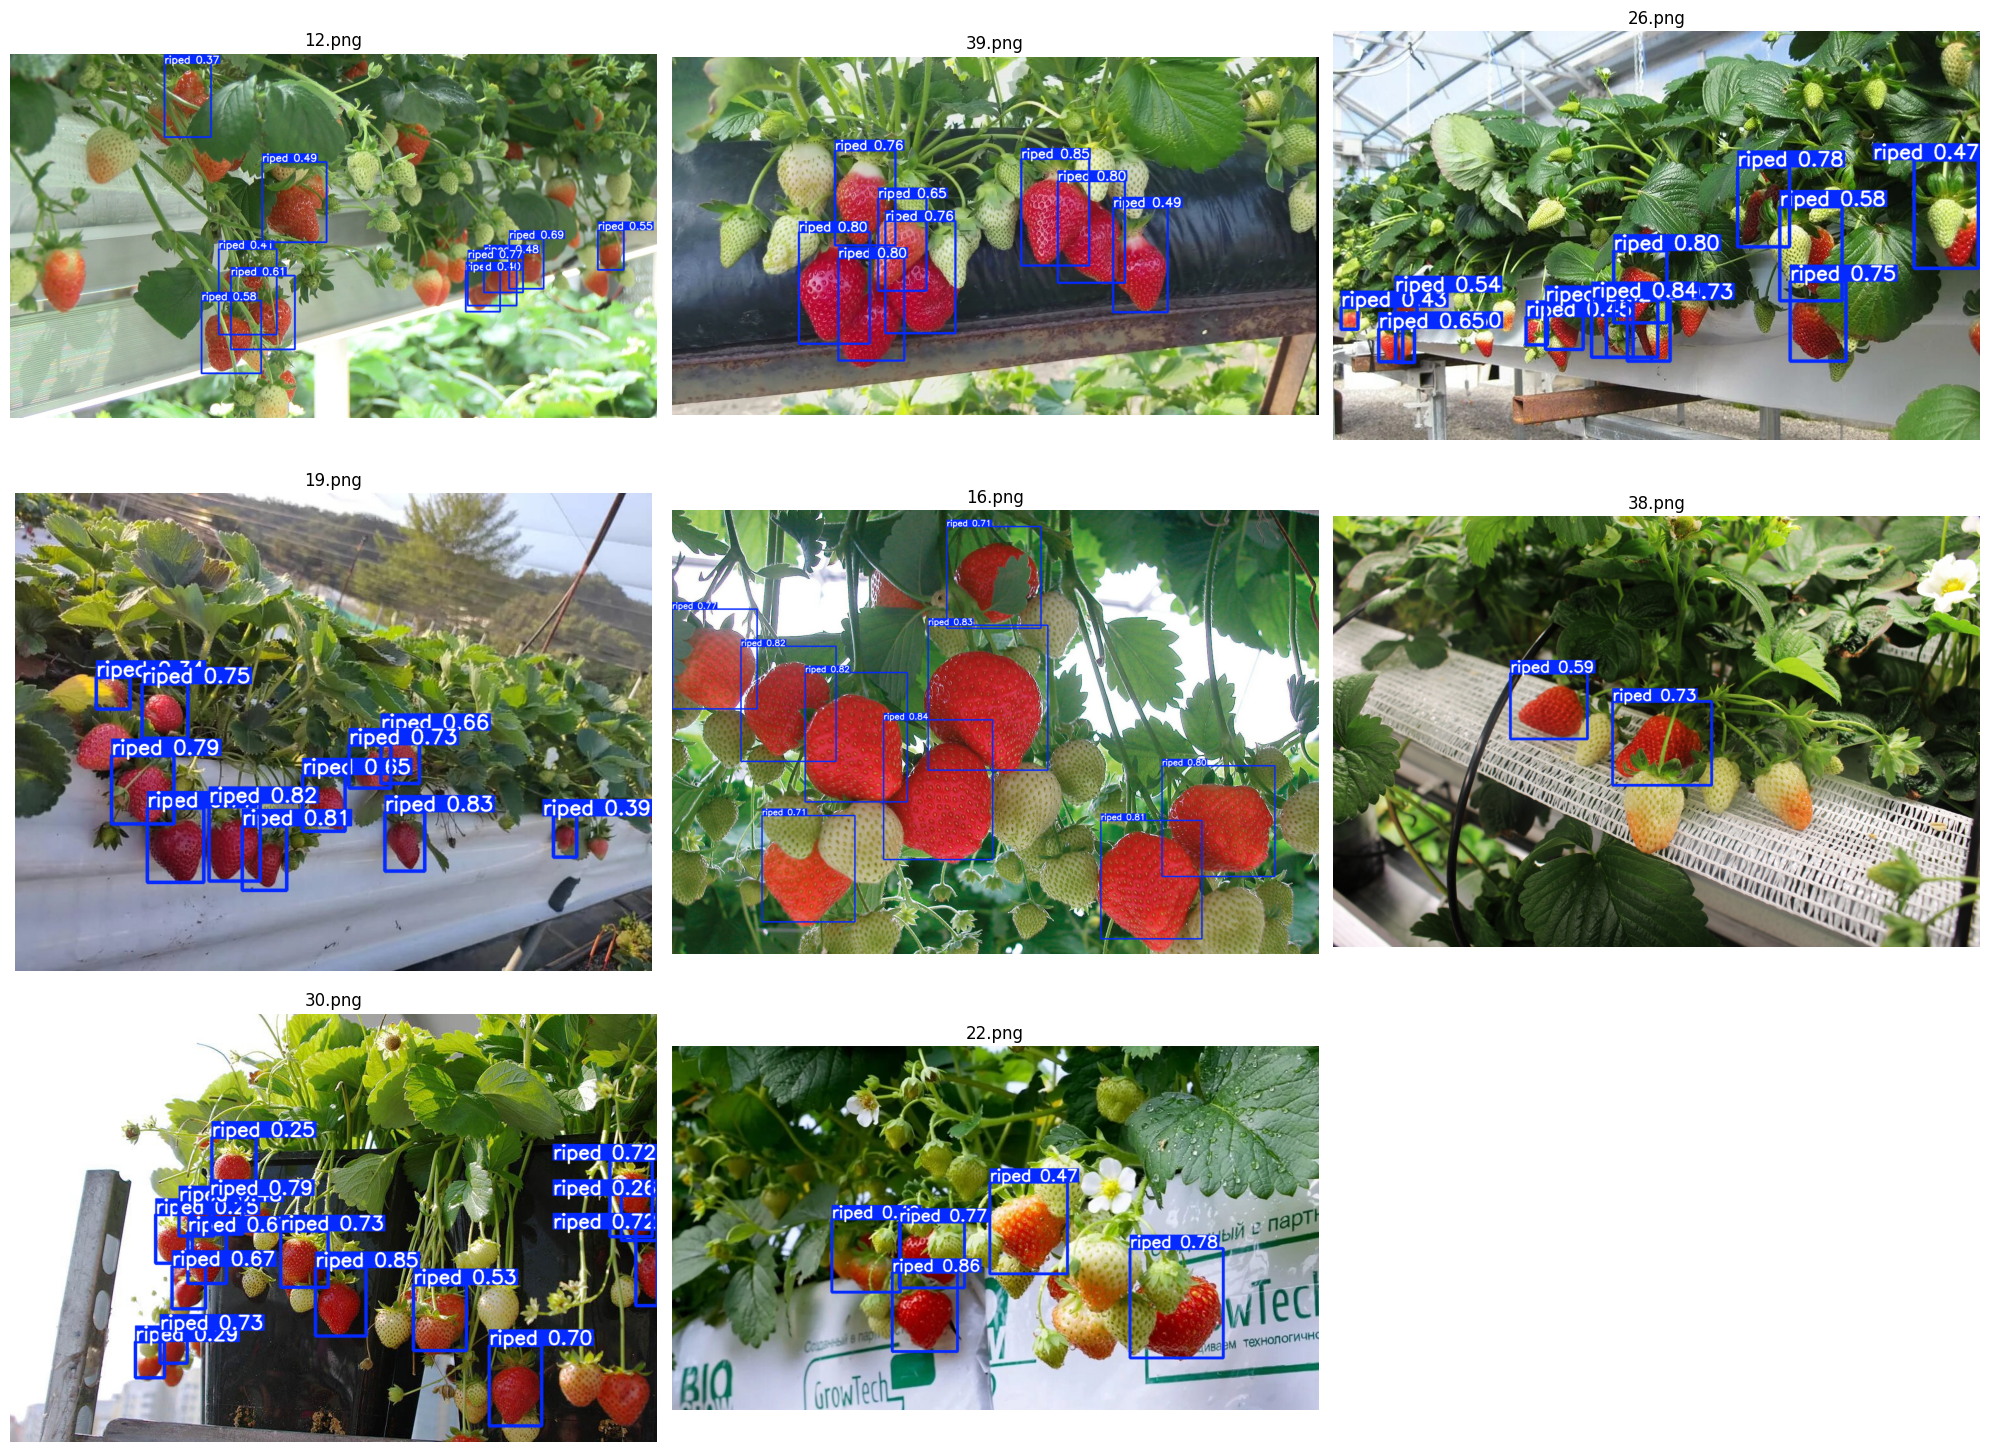

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

output_dir = '/content/yolov5/runs/detect/exp'

# List all images in the output directory
output_images = [img for img in os.listdir(output_dir) if img.endswith('.jpg') or img.endswith('.png')]

# Number of images per row
images_per_row = 3

# Calculate the number of rows needed
num_rows = (len(output_images) + images_per_row - 1) // images_per_row

# Create a figure with a grid of subplots
plt.figure(figsize=(20, 5 * num_rows))

for i, image_name in enumerate(output_images):
    image_path = os.path.join(output_dir, image_name)

    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate subplot index
    plt.subplot(num_rows, images_per_row, i + 1)
    plt.imshow(image_rgb)
    plt.title(image_name)
    plt.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()
